# Results

## Pair dispersion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
scripts_path = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
sys.path.append(scripts_path)
from functions_pair_dispersion import get_trajectory, create_trajectories_and_times_list, create_mask_trajectories_optimized, temporal_interpolation, distance_pair, K_pair, apply_mask_KD, calculate_pair_separation_pair_diffusivity_and_mask_pair
import pandas as pd

from datetime import date
import os
from matplotlib.lines import Line2D
import cmocean.cm as cmo

import jax
import jax.numpy as jnp
from jaxtyping import Array, Float, Int, Real
import xarray as xr


from pastax.trajectory import Trajectory

In [2]:
# Figure styling
from matplotlib import rc
import matplotlib as mpl

rc('lines',  markersize=10)
rc("legend", fontsize=12)
rc("axes", labelsize=20)
rc("xtick", labelsize=12)
rc("ytick", labelsize=12)
rc("lines", linewidth=1.5)

mpl.rcParams['font.family'] = ['serif']
mpl.rcParams['font.serif'] = ['Times New Roman']+ mpl.rcParams['font.serif']
mpl.rcParams["mathtext.fontset"] = "stix"
#mpl.rcParams['text.usetex'] = True

cmap = plt.colormaps["ocean"]
cmap = cmo.speed

In [3]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_disable_jit", False)

In [4]:
base_dir = "../data/drifters"
l2_dir = f"{base_dir}/l2"


spot_l2_df = pd.read_parquet(os.path.join(l2_dir, "spot_l2_df.parquet"))

spot_l2_df['deploy_date'] = pd.to_datetime(spot_l2_df['deploy_time']).dt.date

date_deployment_1 = date(2025, 5, 12)
date_deployment_2 = date(2025, 5, 18)
date_deployment_3 = date(2025, 5, 24)
date_deployment_4 = date(2025, 5, 30)

drifters_deployment_1 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_1]['drifter_id'].unique()
drifters_deployment_2 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_2]['drifter_id'].unique()
drifters_deployment_3 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_3]['drifter_id'].unique()
drifters_deployment_4 = spot_l2_df[spot_l2_df['deploy_date'] == date_deployment_4]['drifter_id'].unique()


def create_trajectories_and_times_list(drifters_id, spot_l2_df):
    traj_list = []
    for i in range(len(drifters_id)):
        drifter_id = drifters_id[i]
        df = spot_l2_df[spot_l2_df["drifter_id"] == drifter_id]

        traj = Trajectory.from_array(
            jnp.stack((jnp.asarray(df['lat']), jnp.asarray(df['lon'])), axis=-1), 
            jnp.asarray(np.asarray(df['time']).astype("datetime64[s]").astype(int)))
        traj_list.append(traj)

    traj_times = []
    for traj in traj_list:
        traj_times.append(np.asarray(traj.times.value).astype("datetime64[s]"))
    return traj_list, traj_times

traj_list_1, traj_times_1 = create_trajectories_and_times_list(drifters_deployment_1, spot_l2_df)
traj_list_2, traj_times_2 = create_trajectories_and_times_list(drifters_deployment_2, spot_l2_df)
traj_list_3, traj_times_3 = create_trajectories_and_times_list(drifters_deployment_3, spot_l2_df)
traj_list_4, traj_times_4 = create_trajectories_and_times_list(drifters_deployment_4, spot_l2_df)



dt = 30*60 # in seconds
ts_1 = np.arange(date_deployment_1, np.datetime64('now'), np.timedelta64(30,'m'))
ts_2 = np.arange(date_deployment_2, np.datetime64('now'), np.timedelta64(30,'m'))
ts_3 = np.arange(date_deployment_3, np.datetime64('now'), np.timedelta64(30,'m'))
ts_4 = np.arange(date_deployment_4, np.datetime64('now'), np.timedelta64(30,'m'))

masks_time_1 = create_mask_trajectories_optimized(traj_list_1, traj_times_1, ts_1)
masks_time_2 = create_mask_trajectories_optimized(traj_list_2, traj_times_2, ts_2)
masks_time_3 = create_mask_trajectories_optimized(traj_list_3, traj_times_3, ts_3)
masks_time_4 = create_mask_trajectories_optimized(traj_list_4, traj_times_4, ts_4)

interpolated_trajs_1 = temporal_interpolation(traj_list_1, masks_time_1, ts_1, traj_times_1)
interpolated_trajs_2 = temporal_interpolation(traj_list_2, masks_time_2, ts_2, traj_times_2)
interpolated_trajs_3 = temporal_interpolation(traj_list_3, masks_time_3, ts_3, traj_times_3)
interpolated_trajs_4 = temporal_interpolation(traj_list_4, masks_time_4, ts_4, traj_times_4)

Ds_1, Ks_1, mask_pair_1 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_1, masks_time_1, dt)
Ds_2, Ks_2, mask_pair_2 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_2, masks_time_2, dt)
Ds_3, Ks_3, mask_pair_3 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_3, masks_time_3, dt)
Ds_4, Ks_4, mask_pair_4 = calculate_pair_separation_pair_diffusivity_and_mask_pair(interpolated_trajs_4, masks_time_4, dt)


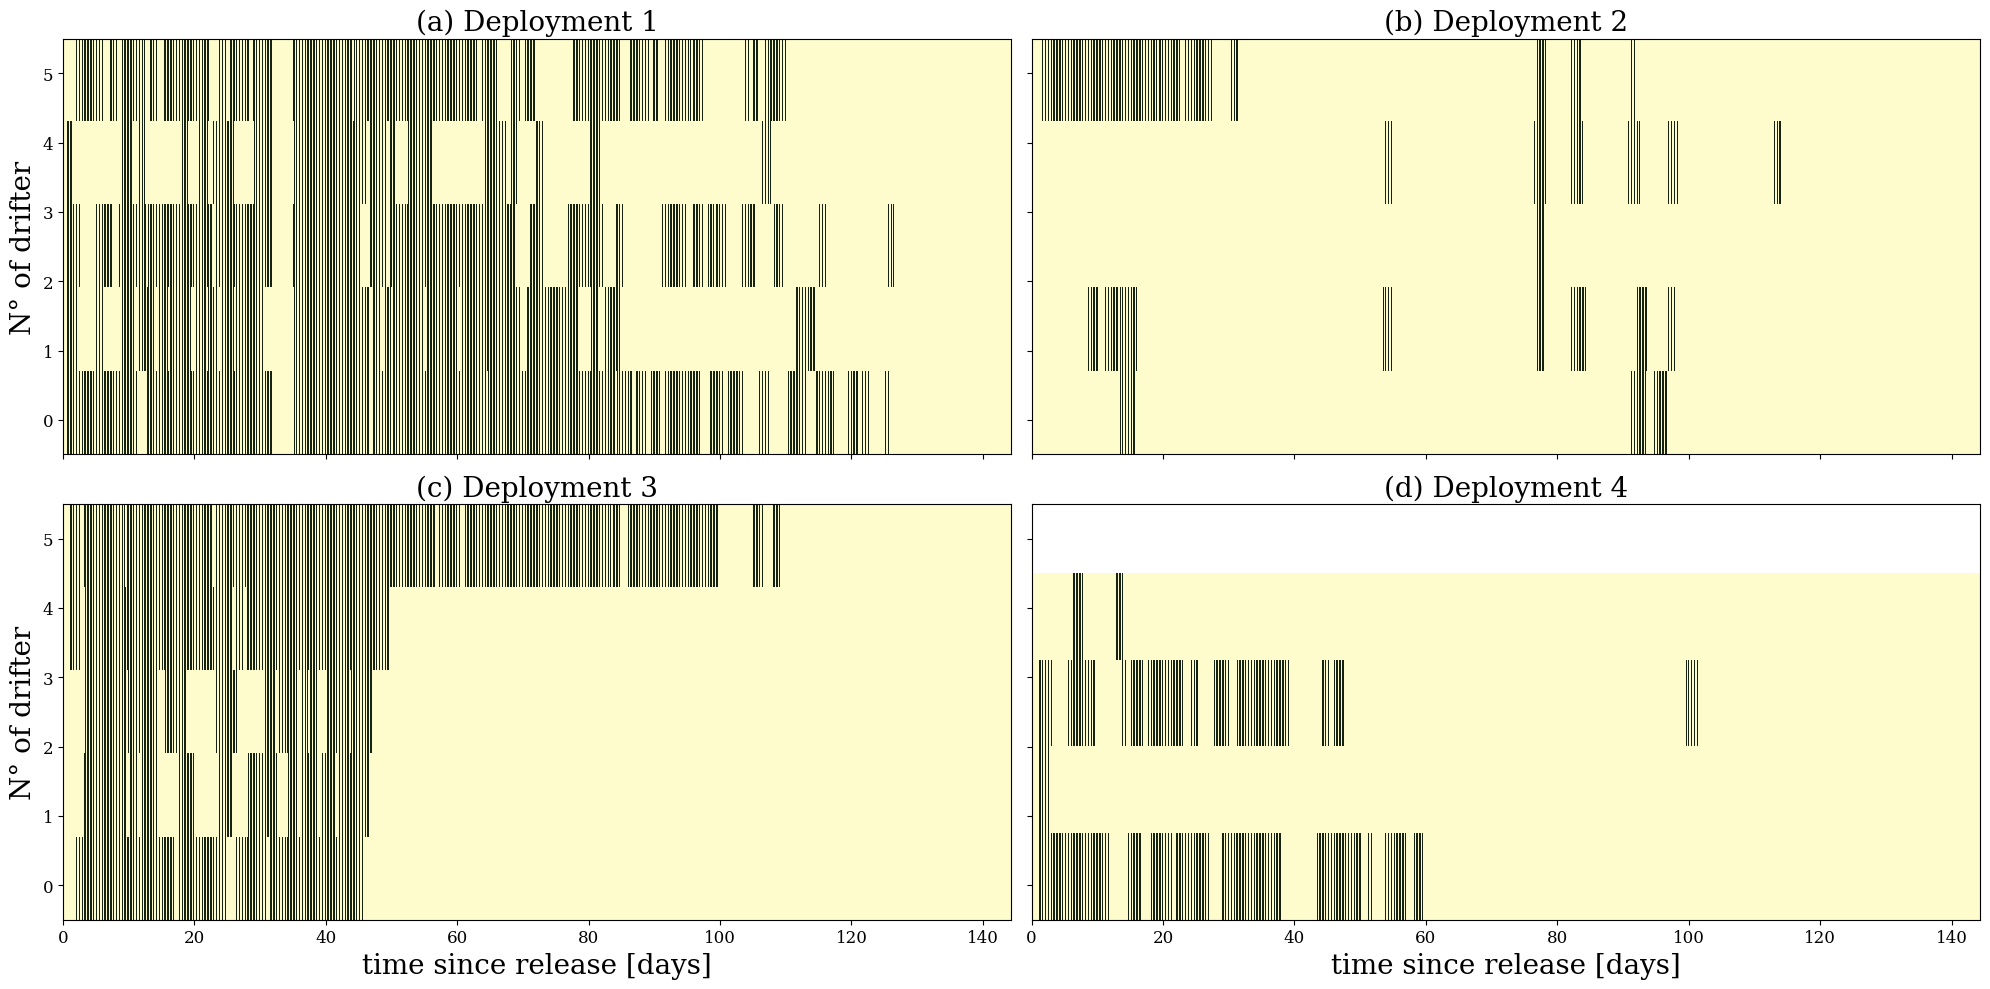

In [65]:
fig, ax = plt.subplots(2,2, sharex = True, sharey = True, figsize = (20,10))

ax[0,0].imshow(masks_time_1, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_1.shape[1]*30/1440, -0.5, masks_time_1.shape[0] + 0.5))
ax[0,1].imshow(masks_time_2, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_2.shape[1]*30/1440, -0.5, masks_time_2.shape[0] + 0.5))
ax[1,0].imshow(masks_time_3, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_3.shape[1]*30/1440, -0.5, masks_time_3.shape[0] + 0.5))
ax[1,1].imshow(masks_time_4, aspect='auto', interpolation='none', cmap=cmo.speed, extent = (0,masks_time_4.shape[1]*30/1440, -0.5, masks_time_4.shape[0] + 0.5))

ax[0,0].set_title('(a) Deployment 1', fontsize = 20)
ax[0,1].set_title('(b) Deployment 2', fontsize = 20)
ax[1,0].set_title('(c) Deployment 3', fontsize = 20)
ax[1,1].set_title('(d) Deployment 4', fontsize = 20)

ax[0,0].set_ylabel('N° of drifter')
ax[1,0].set_ylabel('N° of drifter')

ax[0,0].set_ylim(-0.5, masks_time_1.shape[0] + 0.5)

ax[1,0].set_xlabel('time since release [days]')
ax[1,1].set_xlabel('time since release [days]')

plt.tight_layout()
plt.show()

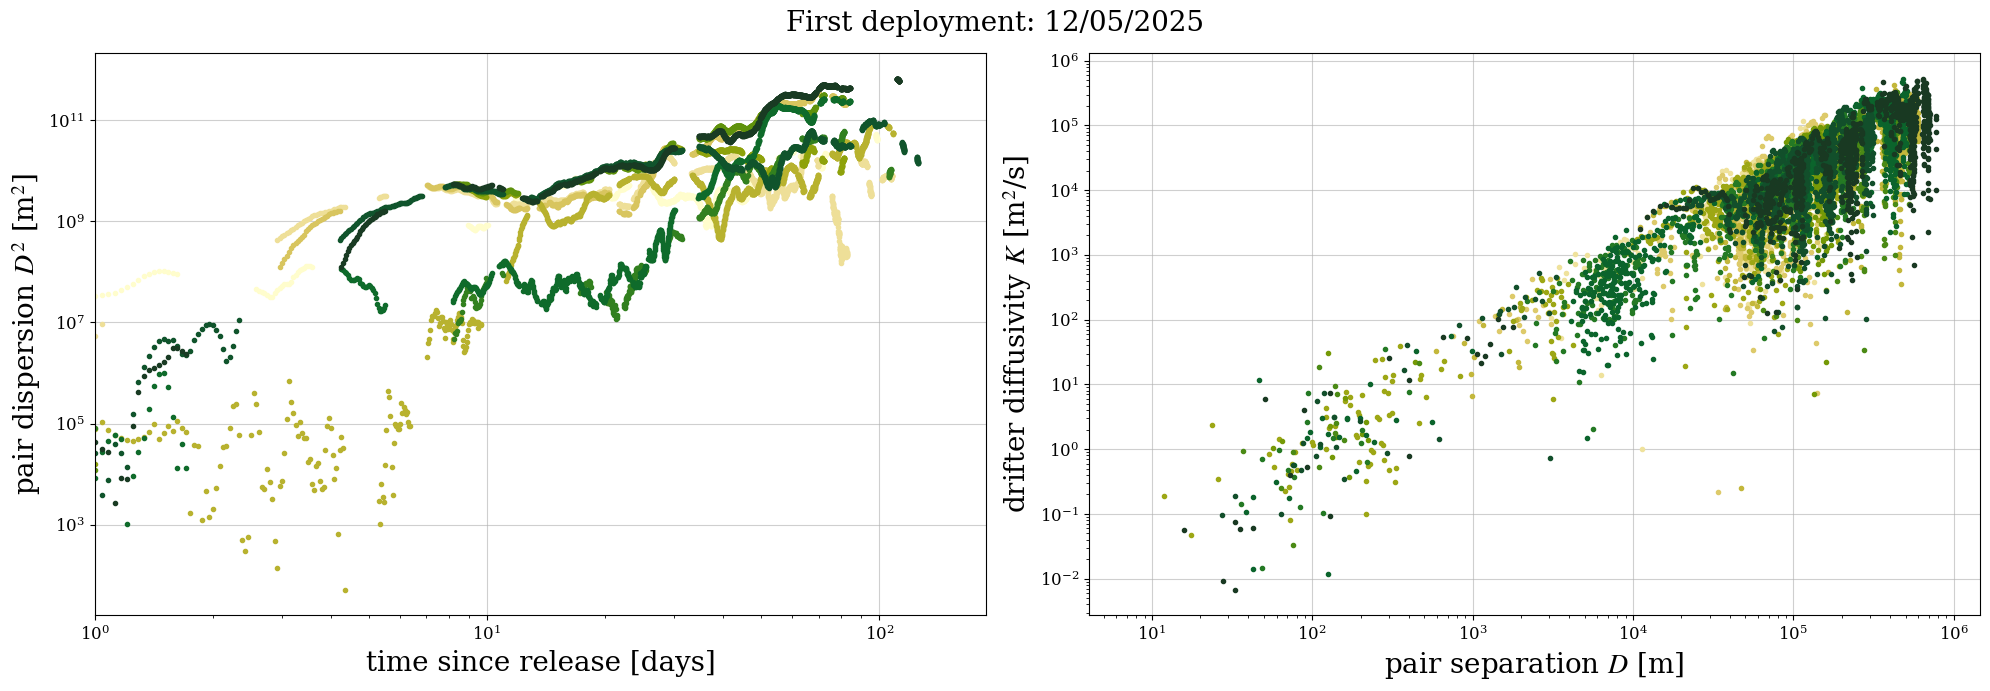

In [6]:
N = len(interpolated_trajs_1)
N_pairs = int(N*(N-1)/2)


# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# First subplot - Pair dispersion vs time
for i in range(N_pairs):
    t_pair = ts_1[mask_pair_1[i]]
    t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
    t_pair_days = t_pair/(24*60*60)
    ax1.plot(t_pair_days, Ds_1[i]**2, c=cmap(i/N_pairs), marker='o', 
             markersize=3, linestyle='', label=str(i))

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(alpha=0.6)
ax1.set_ylabel('pair dispersion $D^2$ [m$^2$]')
ax1.set_xlabel('time since release [days]')
ax1.set_xlim(xmin=1)

# Second subplot - Diffusivity vs pair separation
for i in range(N_pairs):
    ax2.plot(Ds_1[i], Ks_1[i], c=cmap((i+1)/(N_pairs+1)), marker='o', 
             markersize=3, linestyle='', label=str(i))

max_dist = np.max([np.max(Ds_1[i]) for i in range(len(Ds_1))])


ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(alpha=0.6)
ax2.set_xlabel('pair separation $D$ [m]')
ax2.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

plt.suptitle('First deployment: 12/05/2025', fontsize = 20)
plt.tight_layout()
plt.show()

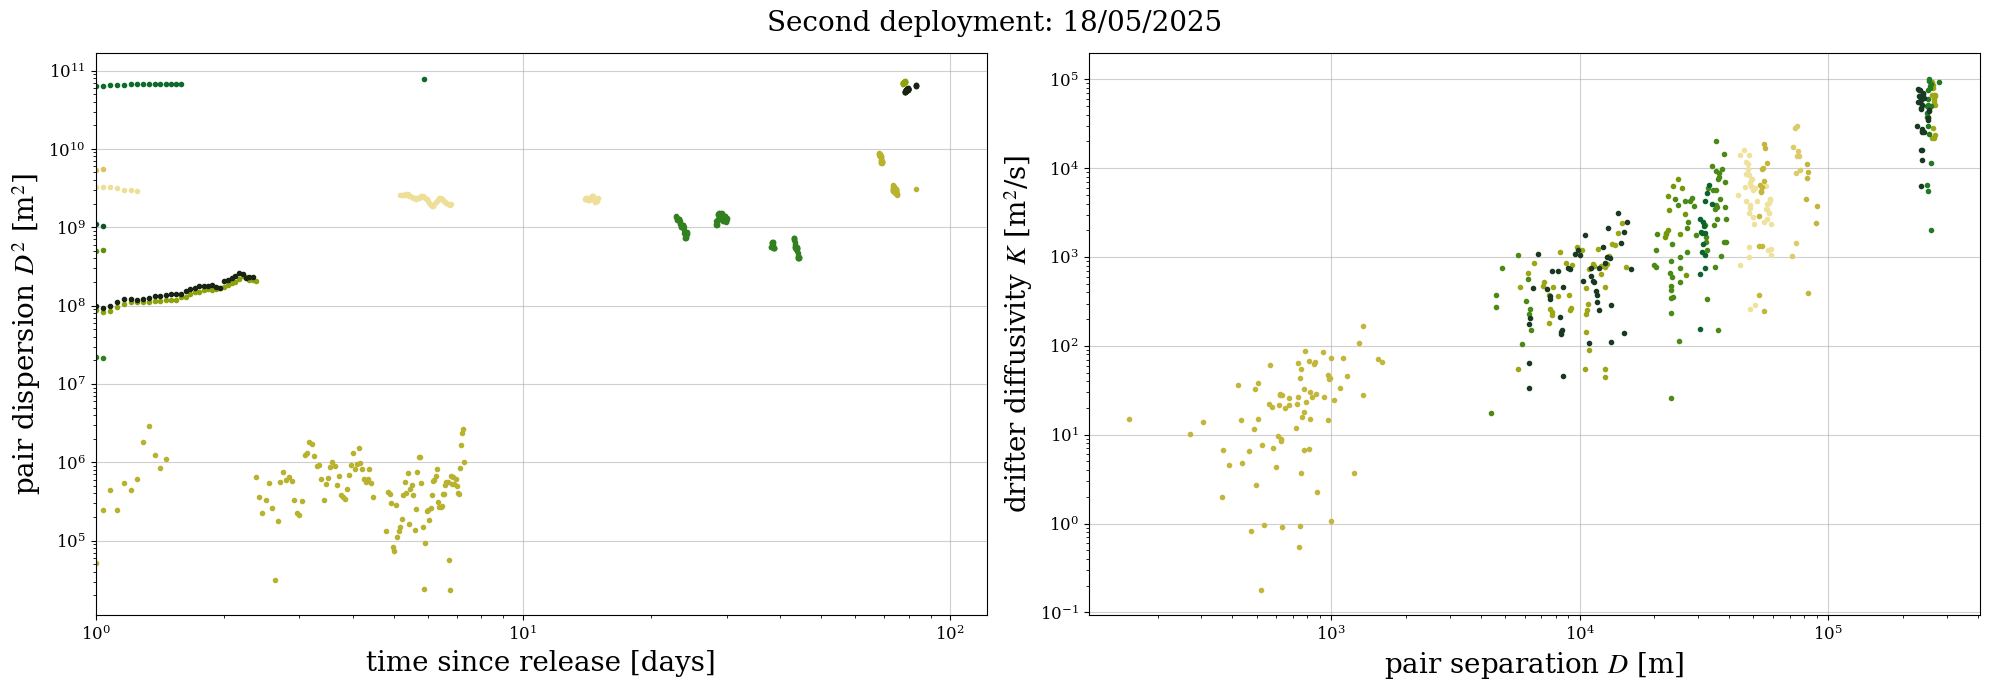

In [73]:
N = len(interpolated_trajs_2)
N_pairs = int(N*(N-1)/2)


# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# First subplot - Pair dispersion vs time
for i in range(N_pairs):
    try:
        t_pair = ts_2[mask_pair_2[i]]
        t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
        t_pair_days = t_pair/(24*60*60)
        ax1.plot(t_pair_days, Ds_2[i]**2, c=cmap((i+1)/N_pairs), marker='o', 
                 markersize=3, linestyle='', label=str(i))
    except:
        pass

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(alpha=0.6)
ax1.set_ylabel('pair dispersion $D^2$ [m$^2$]')
ax1.set_xlabel('time since release [days]')
ax1.set_xlim(xmin=1)

# Second subplot - Diffusivity vs pair separation
for i in range(N_pairs):
    ax2.plot(Ds_2[i], Ks_2[i], c=cmap((i+1)/(N_pairs+1)), marker='o', 
             markersize=3, linestyle='', label=str(i))

#max_dist = np.max([np.max(Ds_4[i]) for i in range(len(Ds_4))])


ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(alpha=0.6)
ax2.set_xlabel('pair separation $D$ [m]')
ax2.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

plt.suptitle('Second deployment: 18/05/2025', fontsize = 20)
plt.tight_layout()
plt.show()

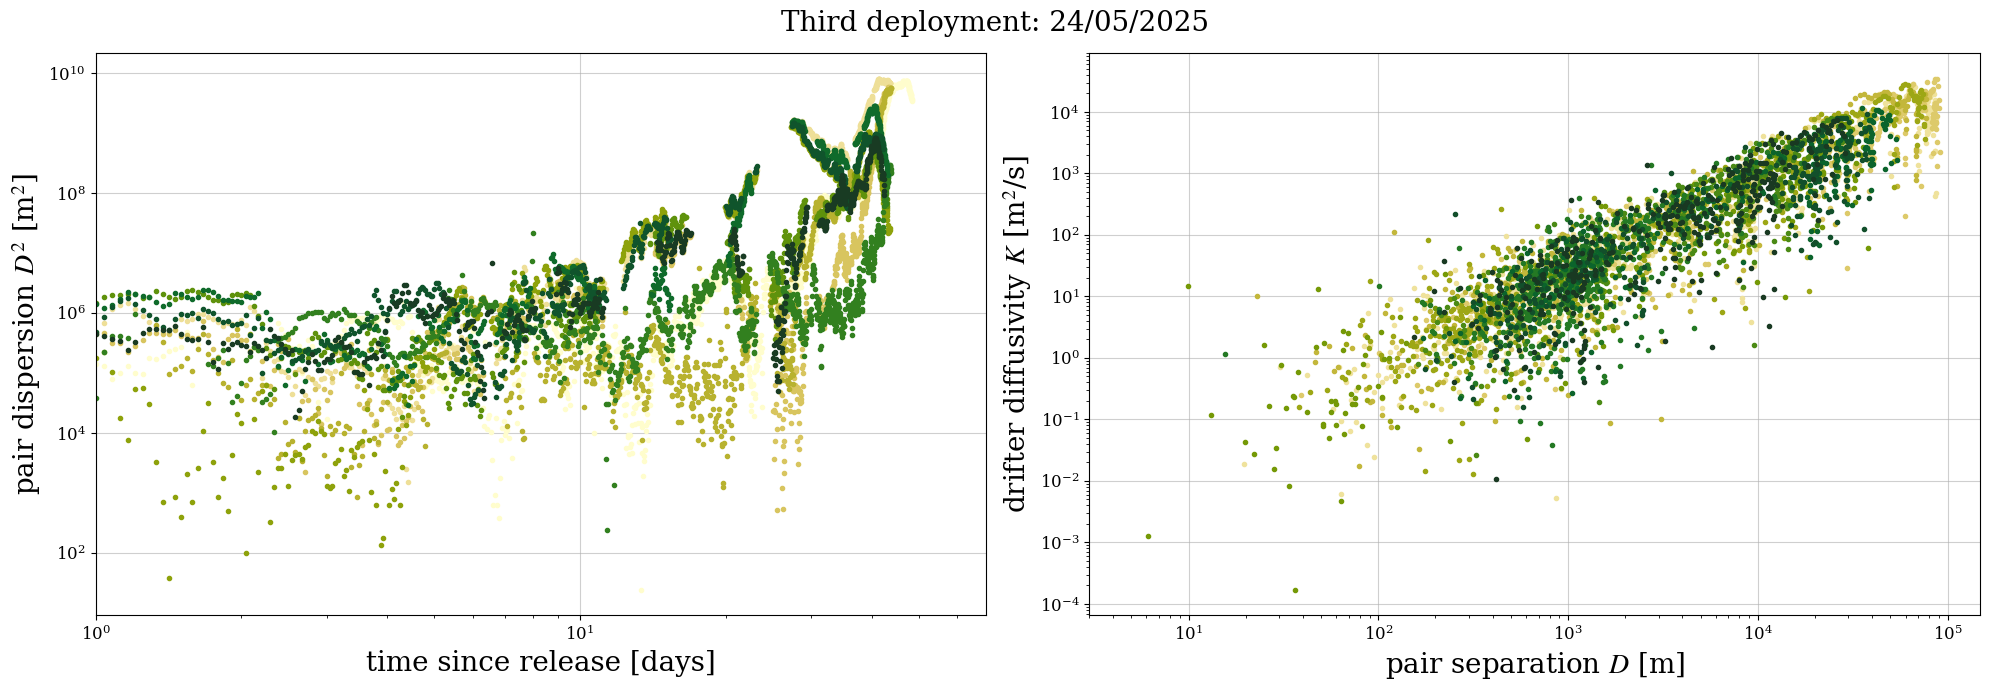

In [7]:
N = len(interpolated_trajs_3)
N_pairs = int(N*(N-1)/2)


# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# First subplot - Pair dispersion vs time
for i in range(N_pairs):
    t_pair = ts_3[mask_pair_3[i]]
    t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
    t_pair_days = t_pair/(24*60*60)
    ax1.plot(t_pair_days, Ds_3[i]**2, c=cmap(i/N_pairs), marker='o', 
             markersize=3, linestyle='', label=str(i))

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(alpha=0.6)
ax1.set_ylabel('pair dispersion $D^2$ [m$^2$]')
ax1.set_xlabel('time since release [days]')
ax1.set_xlim(xmin=1)

# Second subplot - Diffusivity vs pair separation
for i in range(N_pairs):
    ax2.plot(Ds_3[i], Ks_3[i], c=cmap((i+1)/(N_pairs+1)), marker='o', 
             markersize=3, linestyle='', label=str(i))

max_dist = np.max([np.max(Ds_3[i]) for i in range(len(Ds_3))])


ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(alpha=0.6)
ax2.set_xlabel('pair separation $D$ [m]')
ax2.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

plt.suptitle('Third deployment: 24/05/2025', fontsize = 20)
plt.tight_layout()
plt.show()

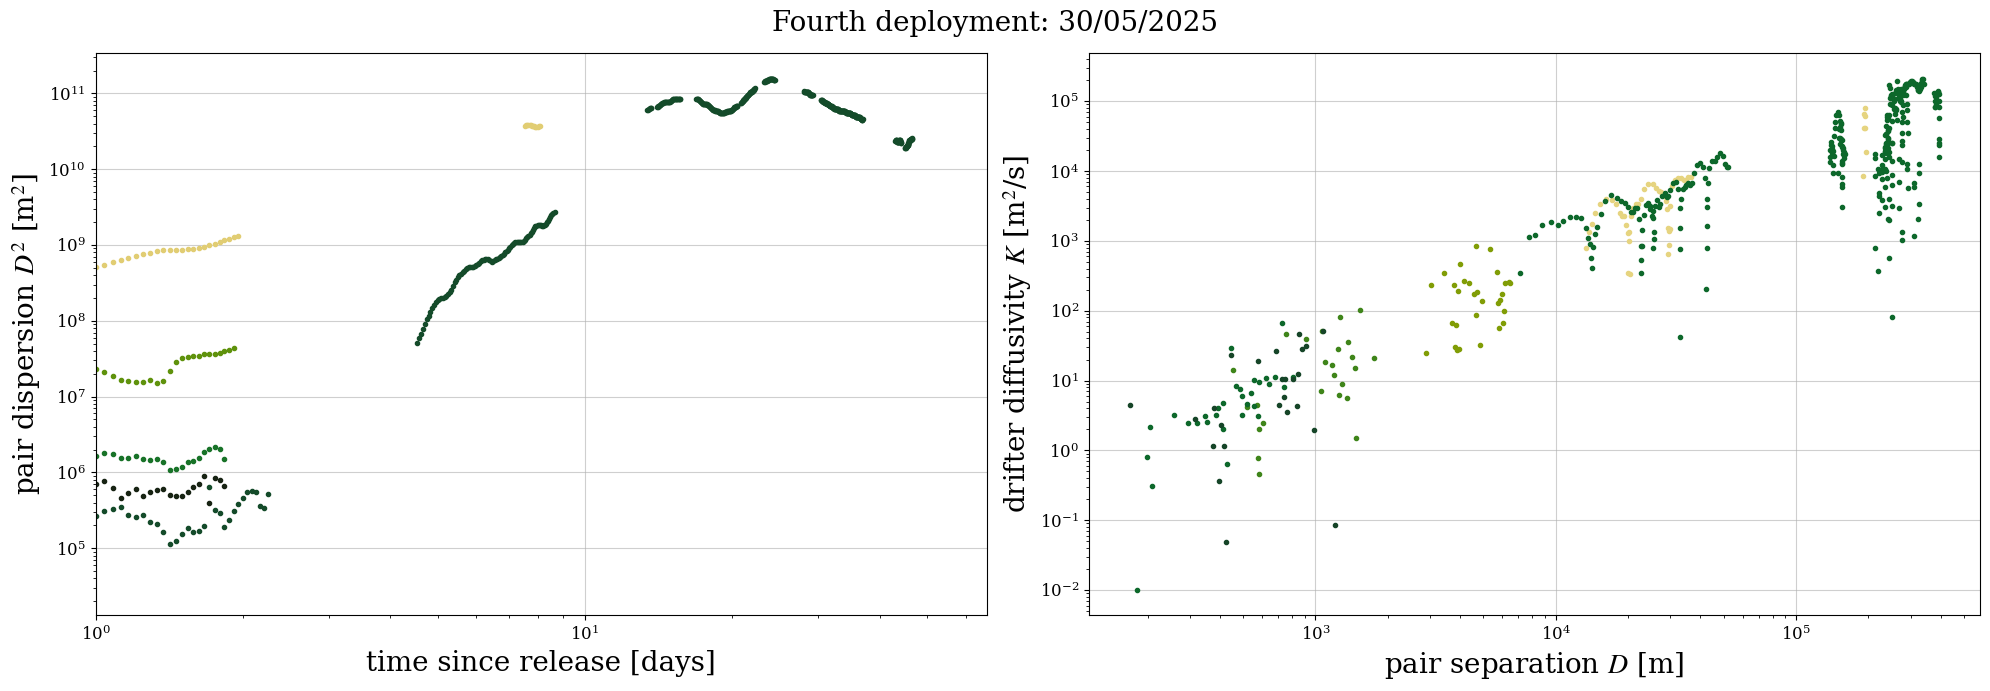

In [72]:
N = len(interpolated_trajs_4)
N_pairs = int(N*(N-1)/2)


# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# First subplot - Pair dispersion vs time
for i in range(N_pairs):
    try:
        t_pair = ts_4[mask_pair_4[i]]
        t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
        t_pair_days = t_pair/(24*60*60)
        ax1.plot(t_pair_days, Ds_4[i]**2, c=cmap((i+1)/N_pairs), marker='o', 
                 markersize=3, linestyle='', label=str(i))
    except:
        pass

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(alpha=0.6)
ax1.set_ylabel('pair dispersion $D^2$ [m$^2$]')
ax1.set_xlabel('time since release [days]')
ax1.set_xlim(xmin=1)

# Second subplot - Diffusivity vs pair separation
for i in range(N_pairs):
    ax2.plot(Ds_4[i], Ks_4[i], c=cmap((i+1)/(N_pairs+1)), marker='o', 
             markersize=3, linestyle='', label=str(i))

#max_dist = np.max([np.max(Ds_4[i]) for i in range(len(Ds_4))])


ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.grid(alpha=0.6)
ax2.set_xlabel('pair separation $D$ [m]')
ax2.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

plt.suptitle('Fourth deployment: 30/05/2025', fontsize = 20)
plt.tight_layout()
plt.show()

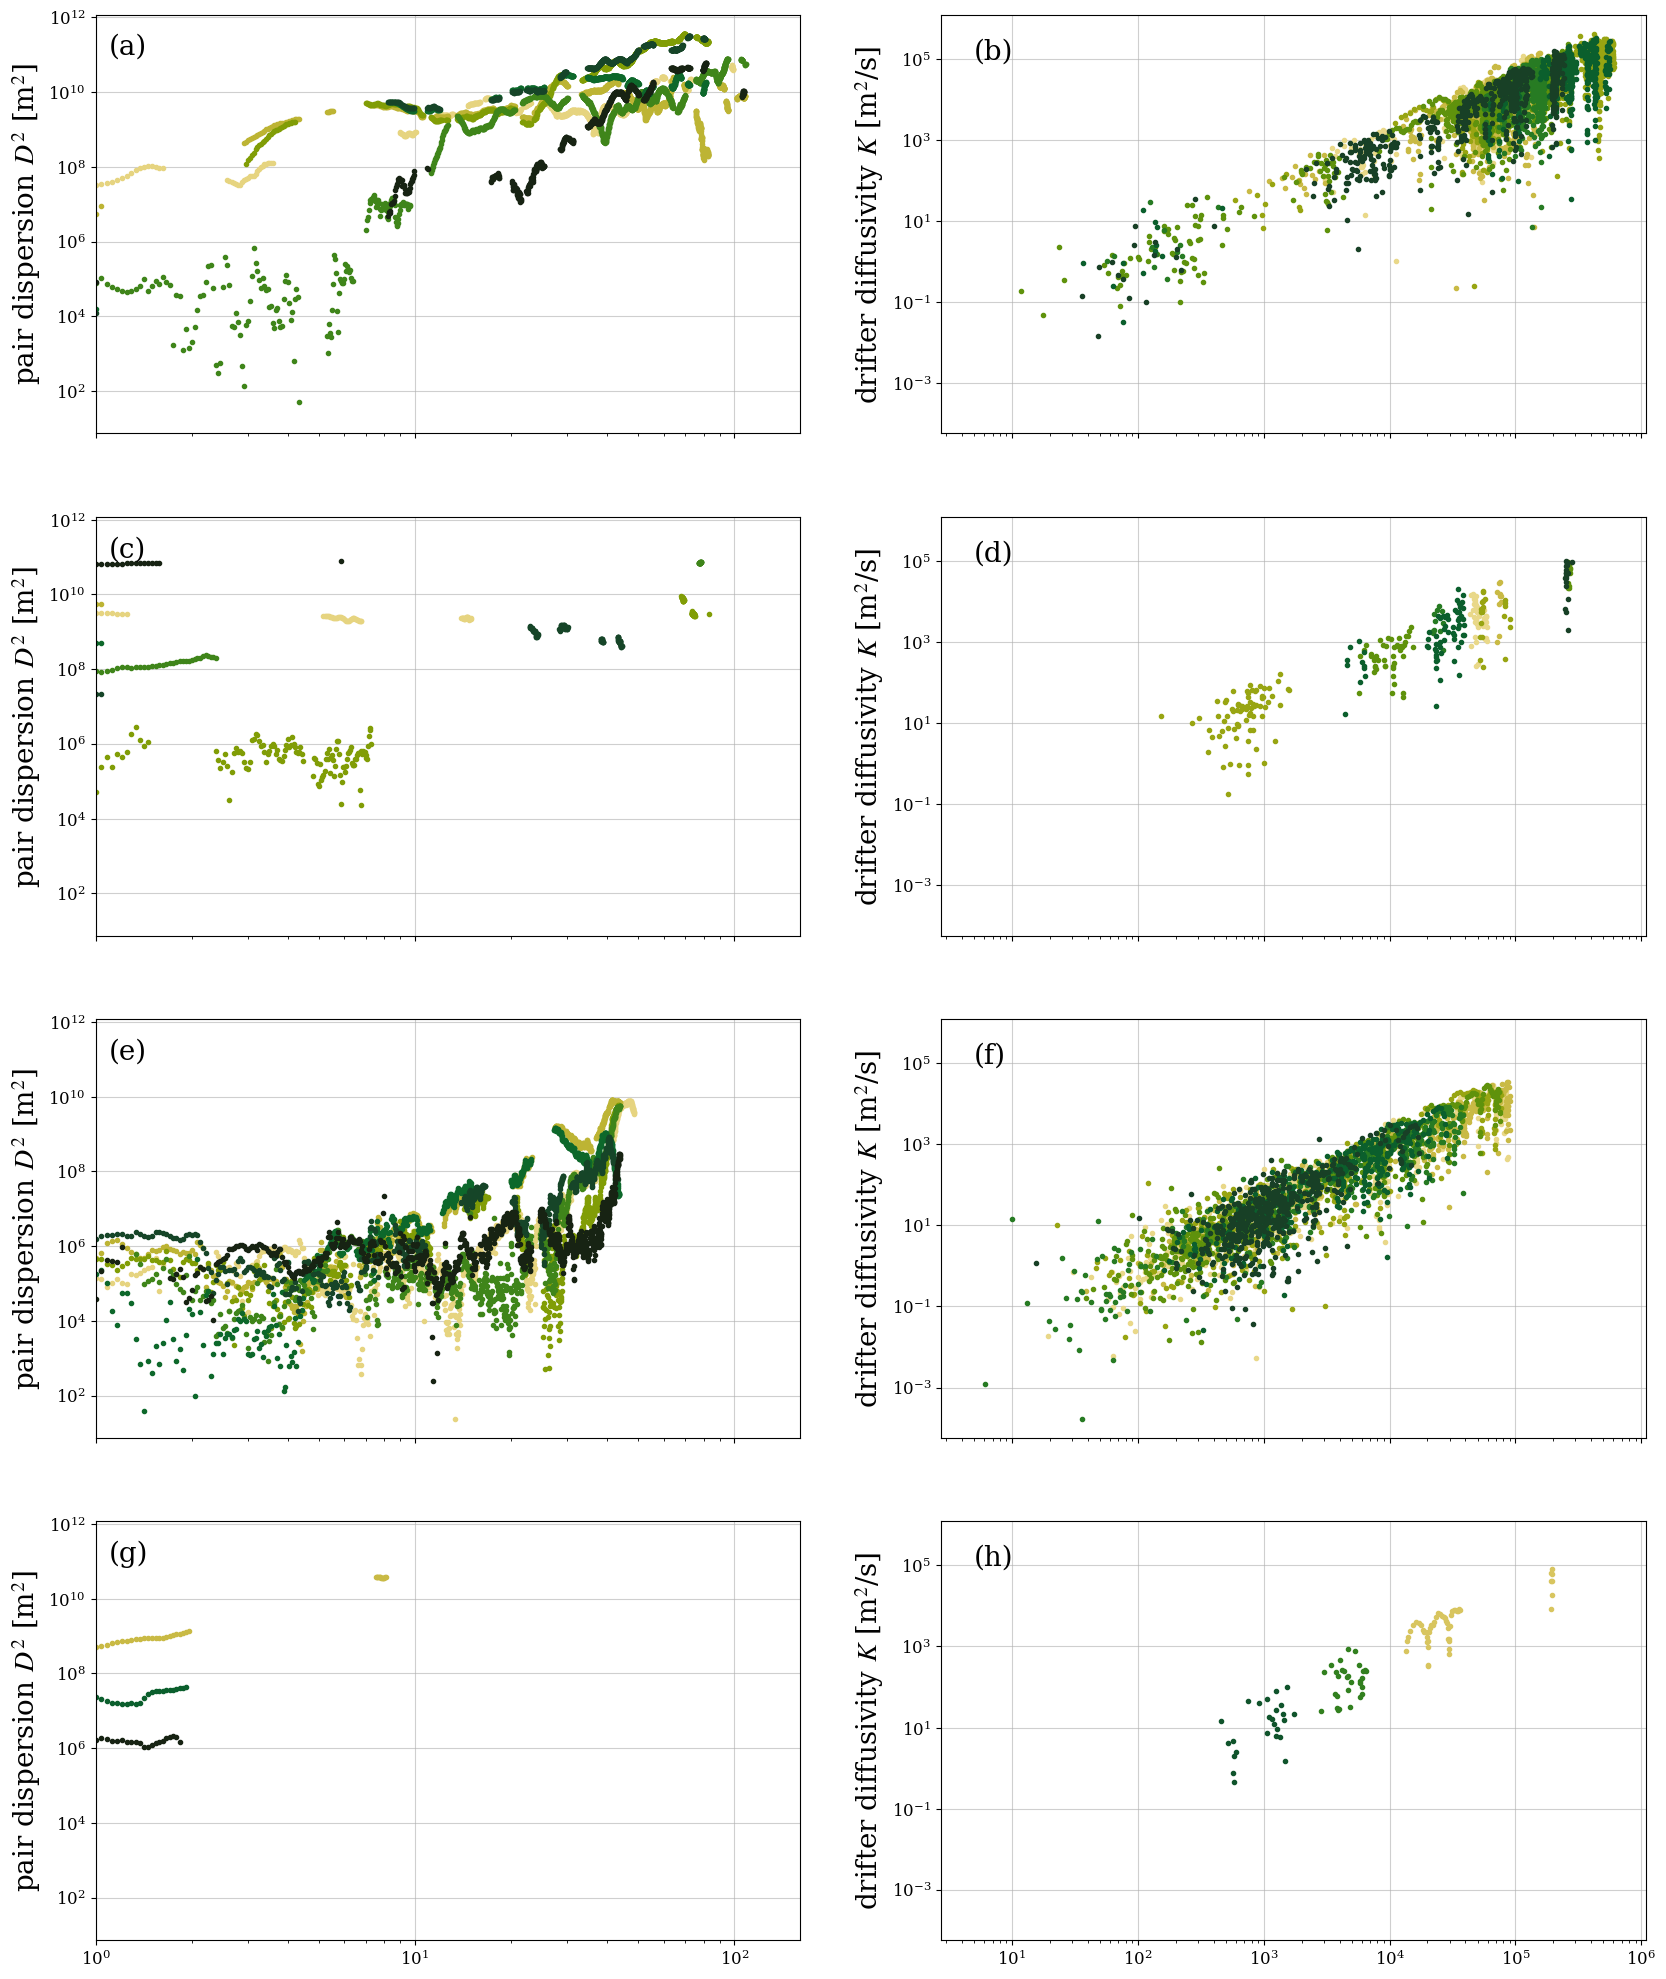

In [88]:

index_plot_D = ['(a)', '(c)', '(e)', '(g)']
index_plot_K = ['(b)', '(d)', '(f)', '(h)']

datasets = [
    (Ds_1, Ks_1, mask_pair_1, ts_1, interpolated_trajs_1),
    (Ds_2, Ks_2, mask_pair_2, ts_2, interpolated_trajs_2),
    (Ds_3, Ks_3, mask_pair_3, ts_3, interpolated_trajs_3),
    (Ds_4, Ks_4, mask_pair_4, ts_4, interpolated_trajs_4)
]

# Create figure with two subplots side by side
fig, axes = plt.subplots(4, 2, sharex = 'col', sharey = 'col', figsize=(20, 25))

for row, (Ds, Ks, mask_pair, ts, interpolated_trajs) in enumerate(datasets):
    ax1 = axes[row, 0]  # Left column (dispersion vs time)
    ax2 = axes[row, 1]  # Right column (diffusivity vs separation)
    

    N = len(interpolated_trajs)
    N_pairs = int(N*(N-2)/2)

    # First subplot - Pair dispersion vs time
    for i in range(N_pairs):
        try:
            t_pair = ts[mask_pair[i]]
            t_pair = t_pair[:-1].astype(int) - np.datetime64(t_pair[0]).astype(int)
            t_pair_days = t_pair/(24*60*60)
            ax1.plot(t_pair_days, Ds[i]**2, c=cmap((i+1)/N_pairs), marker='o', 
                     markersize=3, linestyle='', label=str(i))
        except:
            pass

    
    ax1.text(1.1, 10e10, index_plot_D[row], fontsize = 20)

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(alpha=0.6)
    ax1.set_ylabel('pair dispersion $D^2$ [m$^2$]')
    #ax1.set_xlabel('time since release [days]')
    ax1.set_xlim(xmin=1)


    # Second subplot - Diffusivity vs pair separation
    for i in range(N_pairs):
        ax2.plot(Ds[i], Ks[i], c=cmap((i+1)/(N_pairs+1)), marker='o', 
                 markersize=3, linestyle='', label=str(i))

    #max_dist = np.max([np.max(Ds_4[i]) for i in range(len(Ds_4))])


    ax2.text(5, 100000, index_plot_K[row], fontsize = 20)
    
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax2.grid(alpha=0.6)
    #ax2.set_xlabel('pair separation $D$ [m]')
    ax2.set_ylabel('drifter diffusivity $K$ [m$^2$/s]')

#plt.suptitle('Fourth deployment: 30/05/2025', fontsize = 20)
#plt.tight_layout()
plt.show()

### Finite-scale Lyapunov Exponent